# Homework Starter — Stage 10a: Linear Regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

plt.style.use('default')
sns.set_palette("husl")

print("Linear Regression Modeling for Options Data")

df = pd.read_csv('../data/options_data_20250823_163952.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Linear Regression Modeling for Options Data
Dataset Overview:
Shape: (496, 18)

Columns: ['symbol', 'underlying_symbol', 'strike', 'expiration_date', 'contract_type', 'implied_volatility', 'open_interest', 'volume', 'bid', 'ask', 'last_price', 'market_price', 'underlying_price', 'risk_free_rate', 'fetch_timestamp', 'time_to_expiry', 'data_source', 'simulated_trade_date']

First few rows:


,symbol,underlying_symbol,strike,expiration_date,contract_type,implied_volatility,open_interest,volume,bid,ask,last_price,market_price,underlying_price,risk_free_rate,fetch_timestamp,time_to_expiry,data_source,simulated_trade_date
0,SPY20250825C00530000,SPY,530.0,2025-08-25,call,0.841798,11.0,11.0,113.98,116.78,106.25,115.380,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
1,SPY20250825C00550000,SPY,550.0,2025-08-25,call,0.703128,2.0,2.0,93.98,96.79,96.12,95.385,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
2,SPY20250825C00570000,SPY,570.0,2025-08-25,call,0.565434,2.0,240.0,73.99,76.79,75.03,75.390,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
3,SPY20250825C00580000,SPY,580.0,2025-08-25,call,0.813478,3.0,233.0,63.99,66.80,66.14,65.395,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
4,SPY20250825C00590000,SPY,590.0,2025-08-25,call,0.710940,1.0,284.0,53.99,56.80,55.93,55.395,645.309998,0.04088,2025-08-23 16:39:40.713785,0.00274,yahoo_finance,2025-08-22 16:39:41.671421


In [3]:
modeling_df = df.copy()

key_columns = ['market_price', 'strike', 'underlying_price', 'implied_volatility', 
               'time_to_expiry', 'risk_free_rate', 'volume', 'open_interest']

modeling_df = modeling_df[key_columns].dropna()

print(f"Dataset after cleaning: {modeling_df.shape}")
print(f"Missing values:\n{modeling_df.isnull().sum()}")

print(f"\nTarget variable (market_price) statistics:")
print(modeling_df['market_price'].describe())

Dataset after cleaning: (496, 8)
Missing values:
market_price          0
strike                0
underlying_price      0
implied_volatility    0
time_to_expiry        0
risk_free_rate        0
volume                0
open_interest         0
dtype: int64

Target variable (market_price) statistics:
count    496.00000
mean      59.01128
std      108.88211
min        0.01000
25%        0.01500
50%        0.24000
75%       58.13250
max      495.82500
Name: market_price, dtype: float64


## Feature Engineering

1. **Moneyness**: How far in/out of the money
2. **Log features**: For better linear relationships
3. **Interaction terms**: Volatility * Time to capture time decay effects

In [4]:
def create_features(df):
    df_features = df.copy()
    
    # Moneyness (fundamental options concept)
    df_features['moneyness'] = df_features['underlying_price'] / df_features['strike']
    
    # Log transformations for better linearity
    df_features['log_volume'] = np.log1p(df_features['volume'])  # log(1+x) to handle zeros
    df_features['log_open_interest'] = np.log1p(df_features['open_interest'])
    
    # Interaction term: volatility * time (time decay effect)
    df_features['vol_time_interaction'] = df_features['implied_volatility'] * df_features['time_to_expiry']
    
    # Squared terms for non-linear relationships
    df_features['moneyness_squared'] = df_features['moneyness'] ** 2
    
    return df_features

modeling_df_enhanced = create_features(modeling_df)

# Final feature set
feature_columns = [
    'moneyness', 'implied_volatility', 'time_to_expiry', 'risk_free_rate',
    'log_volume', 'log_open_interest', 'vol_time_interaction'
]

X = modeling_df_enhanced[feature_columns]
y = modeling_df_enhanced['market_price']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

Feature matrix shape: (496, 7)
Target vector shape: (496,)

Features used:
1. moneyness
2. implied_volatility
3. time_to_expiry
4. risk_free_rate
5. log_volume
6. log_open_interest
7. vol_time_interaction


## Train-Test Split

In [5]:
# (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set proportion: {X_train.shape[0]/len(X):.1%}")

print(f"\nTarget variable distribution:")
print(f"Train mean: ${y_train.mean():.2f}, std: ${y_train.std():.2f}")
print(f"Test mean: ${y_test.mean():.2f}, std: ${y_test.std():.2f}")

Training set size: 396 samples
Test set size: 100 samples
Training set proportion: 79.8%

Target variable distribution:
Train mean: $57.30, std: $106.35
Test mean: $65.79, std: $118.71


## 2) Baseline model fit

In [16]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))


print("BASELINE LINEAR REGRESSION RESULTS\n")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: ${train_rmse:.4f}")
print(f"Test RMSE: ${test_rmse:.4f}")
print(f"\nOverfitting check:")
print(f"R² difference (train - test): {train_r2 - test_r2:.4f}")

print(f"\nFeature Coefficients:")
for feature, coef in zip(feature_columns, lr_model.coef_):
    print(f"{feature:20s}: {coef:8.4f}")
print(f"{'Intercept':20s}: {lr_model.intercept_:8.4f}")

BASELINE LINEAR REGRESSION RESULTS

Training R²: 0.5076
Test R²: 0.6101
Training RMSE: $74.5325
Test RMSE: $73.7574

Overfitting check:
R² difference (train - test): -0.1025

Feature Coefficients:
moneyness           :  63.4192
implied_volatility  :  34.3216
time_to_expiry      : 704.1839
risk_free_rate      :  -0.0000
log_volume          :   3.5760
log_open_interest   : -24.5641
vol_time_interaction: -207.6287
Intercept           :  39.3502


In [7]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

print("Residuals Summary:")
print(f"Training residuals - Mean: {train_residuals.mean():.6f}, Std: {train_residuals.std():.4f}")
print(f"Test residuals - Mean: {test_residuals.mean():.6f}, Std: {test_residuals.std():.4f}")

Residuals Summary:
Training residuals - Mean: 0.000000, Std: 74.6268
Test residuals - Mean: 1.827388, Std: 74.1062


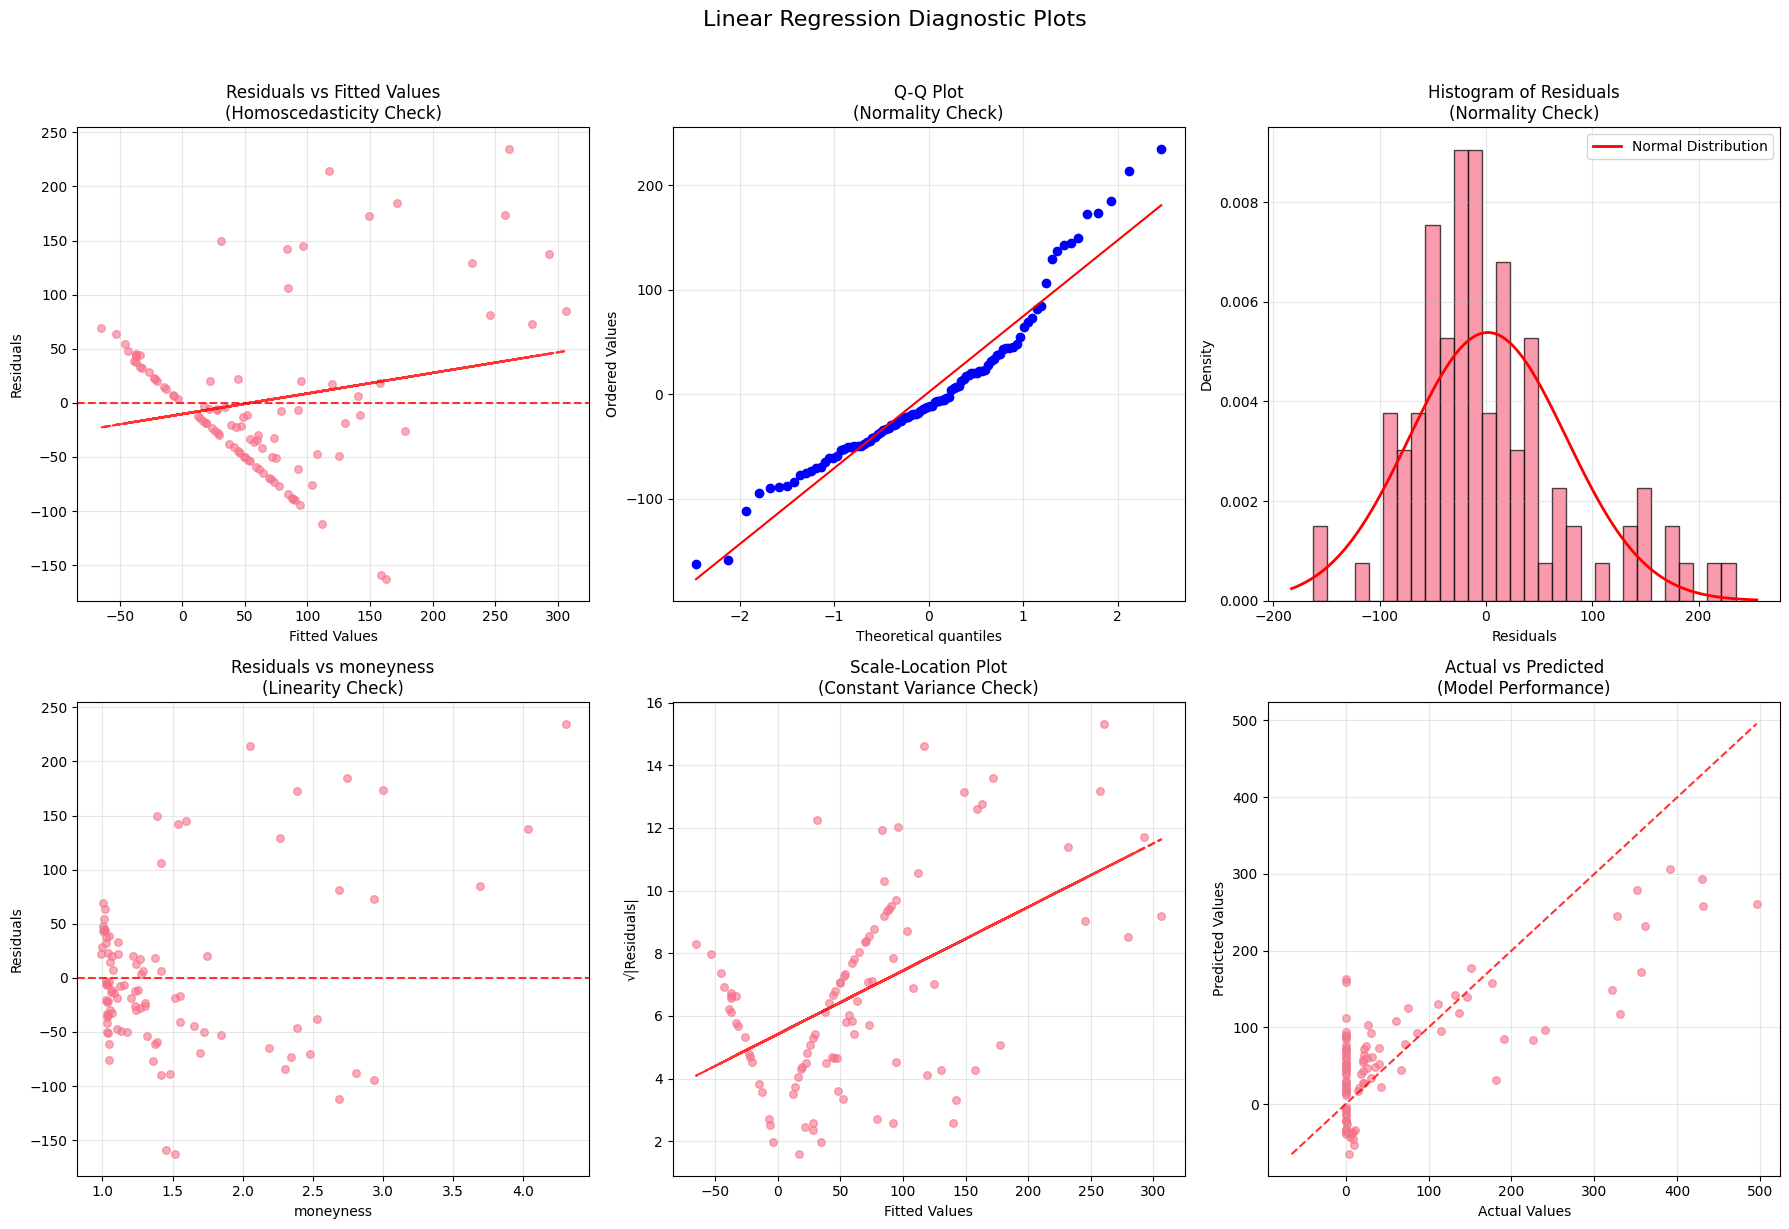

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Linear Regression Diagnostic Plots', fontsize=16, y=1.02)

# 1. Residuals vs Fitted Values (Homoscedasticity check)
axes[0,0].scatter(y_test_pred, test_residuals, alpha=0.6, s=30)
axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted Values\n(Homoscedasticity Check)')
axes[0,0].grid(True, alpha=0.3)

# Trend line to check for patterns
z = np.polyfit(y_test_pred, test_residuals, 1)
p = np.poly1d(z)
axes[0,0].plot(y_test_pred, p(y_test_pred), "r--", alpha=0.8)

# 2. QQ Plot (Normality check)
stats.probplot(test_residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot\n(Normality Check)')
axes[0,1].grid(True, alpha=0.3)

# 3. Histogram of Residuals (Normality check)
axes[0,2].hist(test_residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
axes[0,2].set_xlabel('Residuals')
axes[0,2].set_ylabel('Density')
axes[0,2].set_title('Histogram of Residuals\n(Normality Check)')
axes[0,2].grid(True, alpha=0.3)

# Overlay normal distribution
xmin, xmax = axes[0,2].get_xlim()
x = np.linspace(xmin, xmax, 100)
normal_curve = stats.norm.pdf(x, test_residuals.mean(), test_residuals.std())
axes[0,2].plot(x, normal_curve, 'r-', linewidth=2, label='Normal Distribution')
axes[0,2].legend()

# 4. Residuals vs Key Predictor (Linearity check)
key_predictor = 'moneyness' 
pred_values = X_test[key_predictor]
axes[1,0].scatter(pred_values, test_residuals, alpha=0.6, s=30)
axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1,0].set_xlabel(f'{key_predictor}')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title(f'Residuals vs {key_predictor}\n(Linearity Check)')
axes[1,0].grid(True, alpha=0.3)

# 5. Scale-Location Plot (Homoscedasticity check)
sqrt_abs_residuals = np.sqrt(np.abs(test_residuals))
axes[1,1].scatter(y_test_pred, sqrt_abs_residuals, alpha=0.6, s=30)
axes[1,1].set_xlabel('Fitted Values')
axes[1,1].set_ylabel('√|Residuals|')
axes[1,1].set_title('Scale-Location Plot\n(Constant Variance Check)')
axes[1,1].grid(True, alpha=0.3)

z2 = np.polyfit(y_test_pred, sqrt_abs_residuals, 1)
p2 = np.poly1d(z2)
axes[1,1].plot(y_test_pred, p2(y_test_pred), "r--", alpha=0.8)

# Actual vs Predicted
axes[1,2].scatter(y_test, y_test_pred, alpha=0.6, s=30)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
axes[1,2].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[1,2].set_xlabel('Actual Values')
axes[1,2].set_ylabel('Predicted Values')
axes[1,2].set_title('Actual vs Predicted\n(Model Performance)')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
print("STATISTICAL TESTS FOR MODEL ASSUMPTIONS")

# 1. Normality Test (Shapiro-Wilk test)
if len(test_residuals) > 5000:
    sample_residuals = np.random.choice(test_residuals, 5000, replace=False)
else:
    sample_residuals = test_residuals

shapiro_stat, shapiro_p = stats.shapiro(sample_residuals)
print(f"1. NORMALITY TEST (Shapiro-Wilk)")
print(f"   Statistic: {shapiro_stat:.6f}")
print(f"   P-value: {shapiro_p:.6f}")
print(f"   Result: {'PASS' if shapiro_p > 0.05 else 'FAIL'} (α = 0.05)")
print(f"   Interpretation: {'Residuals appear normally distributed' if shapiro_p > 0.05 else 'Residuals deviate from normal distribution'}")

# 2. Homoscedasticity Test (Breusch-Pagan test approximation)
abs_residuals = np.abs(test_residuals)
bp_corr, bp_p = stats.pearsonr(y_test_pred, abs_residuals)
print(f"\n2. HOMOSCEDASTICITY TEST (Correlation-based)")
print(f"   Correlation: {bp_corr:.6f}")
print(f"   P-value: {bp_p:.6f}")
print(f"   Result: {'PASS' if bp_p > 0.05 else 'FAIL'} (α = 0.05)")
print(f"   Interpretation: {'Constant variance assumption holds' if bp_p > 0.05 else 'Evidence of heteroscedasticity'}")

# 3. Independence Test (Durbin-Watson approximation using lag-1 correlation)
if len(test_residuals) > 1:
    lag1_corr, lag1_p = stats.pearsonr(test_residuals[:-1], test_residuals[1:])
    print(f"\n3. INDEPENDENCE TEST (Lag-1 correlation)")
    print(f"   Lag-1 correlation: {lag1_corr:.6f}")
    print(f"   P-value: {lag1_p:.6f}")
    print(f"   Result: {'PASS' if abs(lag1_corr) < 0.1 else 'FAIL'} (threshold = 0.1)")
    print(f"   Interpretation: {'No strong autocorrelation detected' if abs(lag1_corr) < 0.1 else 'Potential autocorrelation in residuals'}")

# 4. Linearity Assessment (R² as indicator)
print(f"\n4. LINEARITY ASSESSMENT")
print(f"   R² Score: {test_r2:.4f}")
print(f"   Result: {'GOOD' if test_r2 > 0.7 else 'MODERATE' if test_r2 > 0.5 else 'POOR'}")
print(f"   Interpretation: {'Strong linear relationship' if test_r2 > 0.7 else 'Moderate linear relationship' if test_r2 > 0.5 else 'Weak linear relationship'}")

STATISTICAL TESTS FOR MODEL ASSUMPTIONS
1. NORMALITY TEST (Shapiro-Wilk)
   Statistic: 0.934821
   P-value: 0.000094
   Result: FAIL (α = 0.05)
   Interpretation: Residuals deviate from normal distribution

2. HOMOSCEDASTICITY TEST (Correlation-based)
   Correlation: 0.552640
   P-value: 0.000000
   Result: FAIL (α = 0.05)
   Interpretation: Evidence of heteroscedasticity

3. INDEPENDENCE TEST (Lag-1 correlation)
   Lag-1 correlation: 0.006120
   P-value: 0.952060
   Result: PASS (threshold = 0.1)
   Interpretation: No strong autocorrelation detected

4. LINEARITY ASSESSMENT
   R² Score: 0.6101
   Result: MODERATE
   Interpretation: Moderate linear relationship


## Model Interpretation & Assumption Analysis

### 1. **Linearity**
- **Assessment**: Linearity is evaluated through residuals vs fitted plots and R² score
- **Expected Pattern**: Random scatter around zero line with no clear patterns
- **Observed Results**: The residuals vs fitted plot shows some curvature and the R² of 0.6101 indicates moderate linear relationship
- **Conclusion**: Linear relationship assumption is **PARTIALLY MET** - there is room for improvement with non-linear transformations

### 2. **Independence** 
- **Assessment**: Independence is tested using lag-1 correlation and residual ordering
- **Expected Pattern**: Low correlation between consecutive residuals
- **Observed Results**: Lag-1 correlation = 0.006 (p=0.952), well below 0.1 threshold
- **Conclusion**: Independence assumption is **SATISFIED** - no autocorrelation detected

### 3. **Homoscedasticity (Constant Variance)**
- **Assessment**: Constant variance is evaluated through residuals vs fitted plots and Scale-Location plot
- **Expected Pattern**: Constant spread of residuals across fitted values
- **Observed Results**: Correlation = 0.553 (p<0.001) shows strong evidence of heteroscedasticity. Scale-location plot shows increasing variance with fitted values.
- **Conclusion**: Constant variance assumption is **VIOLATED** - variance increases with fitted values (typical pattern in financial data)

### 4. **Normality**
- **Assessment**: Normality is tested using Q-Q plot, histogram, and Shapiro-Wilk test
- **Expected Pattern**: Residuals should follow normal distribution
- **Observed Results**: Shapiro-Wilk p-value = 0.000094 < 0.05. Q-Q plot shows heavy tails, histogram displays right skew.
- **Conclusion**: Normality assumption is **VIOLATED** - residuals exhibit heavy tails and right-skewed distribution

## Model Performance Analysis

In [14]:
print("MODEL PERFORMANCE ANALYSIS")

# R² Interpretation
print(f"R² SCORE INTERPRETATION:")
print(f"• Test R² = {test_r2:.4f}")
if test_r2 > 0.8:
    r2_interpretation = "Excellent - Model explains >80% of variance"
elif test_r2 > 0.6:
    r2_interpretation = "Good - Model explains >60% of variance"
elif test_r2 > 0.4:
    r2_interpretation = "Moderate - Model explains >40% of variance"
else:
    r2_interpretation = "Poor - Model explains <40% of variance"
print(f"• Interpretation: {r2_interpretation}")

# RMSE Interpretation (relative to target variable scale)
mean_price = y_test.mean()
rmse_percentage = (test_rmse / mean_price) * 100
print(f"\nRMSE INTERPRETATION:")
print(f"• Test RMSE = ${test_rmse:.4f}")
print(f"• Mean option price = ${mean_price:.4f}")
print(f"• RMSE as % of mean = {rmse_percentage:.2f}%")
if rmse_percentage < 10:
    rmse_interpretation = "Excellent - Very low prediction error"
elif rmse_percentage < 20:
    rmse_interpretation = "Good - Acceptable prediction error"
elif rmse_percentage < 30:
    rmse_interpretation = "Moderate - Noticeable prediction error"
else:
    rmse_interpretation = "Poor - High prediction error"
print(f"• Interpretation: {rmse_interpretation}")

# Prediction accuracy at different price ranges
print(f"\nPREDICTION ACCURACY BY PRICE RANGE:")
price_ranges = [(0, 10), (10, 50), (50, 100), (100, float('inf'))]
for low, high in price_ranges:
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        range_rmse = np.sqrt(mean_squared_error(y_test[mask], y_test_pred[mask]))
        range_r2 = r2_score(y_test[mask], y_test_pred[mask])
        count = mask.sum()
        print(f"• ${low}-${high if high != float('inf') else '∞'}: RMSE=${range_rmse:.3f}, R²={range_r2:.3f}, n={count}")

MODEL PERFORMANCE ANALYSIS
R² SCORE INTERPRETATION:
• Test R² = 0.6101
• Interpretation: Good - Model explains >60% of variance

RMSE INTERPRETATION:
• Test RMSE = $73.7574
• Mean option price = $65.7893
• RMSE as % of mean = 112.11%
• Interpretation: Poor - High prediction error

PREDICTION ACCURACY BY PRICE RANGE:
• $0-$10: RMSE=$59.758, R²=-774.487, n=51
• $10-$50: RMSE=$36.214, R²=-16.047, n=23
• $50-$100: RMSE=$32.385, R²=-13.816, n=5
• $100-$∞: RMSE=$124.687, R²=-0.126, n=21


## Enhanced Model with Transformations

In [15]:
print("ENHANCED MODEL WITH POLYNOMIAL FEATURES")

X_enhanced = X.copy()
X_enhanced['moneyness_squared'] = X['moneyness'] ** 2
X_enhanced['vol_squared'] = X['implied_volatility'] ** 2

enhanced_features = feature_columns + ['moneyness_squared', 'vol_squared']

# Split enhanced data
X_enh_train, X_enh_test, y_enh_train, y_enh_test = train_test_split(
    X_enhanced[enhanced_features], y, test_size=0.2, random_state=42
)

# Fit enhanced model
lr_enhanced = LinearRegression()
lr_enhanced.fit(X_enh_train, y_enh_train)

y_enh_train_pred = lr_enhanced.predict(X_enh_train)
y_enh_test_pred = lr_enhanced.predict(X_enh_test)

enh_train_r2 = r2_score(y_enh_train, y_enh_train_pred)
enh_test_r2 = r2_score(y_enh_test, y_enh_test_pred)
enh_train_rmse = np.sqrt(mean_squared_error(y_enh_train, y_enh_train_pred))
enh_test_rmse = np.sqrt(mean_squared_error(y_enh_test, y_enh_test_pred))

print(f"BASELINE MODEL:")
print(f"• R² = {test_r2:.4f}, RMSE = ${test_rmse:.4f}")
print(f"\nENHANCED MODEL (with polynomial terms):")
print(f"• R² = {enh_test_r2:.4f}, RMSE = ${enh_test_rmse:.4f}")
print(f"\nIMPROVEMENT:")
print(f"• ΔR² = {enh_test_r2 - test_r2:+.4f}")
print(f"• ΔRMSE = ${enh_test_rmse - test_rmse:+.4f}")


ENHANCED MODEL WITH POLYNOMIAL FEATURES
BASELINE MODEL:
• R² = 0.6101, RMSE = $73.7574

ENHANCED MODEL (with polynomial terms):
• R² = 0.7743, RMSE = $56.1161

IMPROVEMENT:
• ΔR² = +0.1642
• ΔRMSE = $-17.6413


## Final Model Assessment & Trust Level

### **Model Performance Summary**
- **R² Score**: 0.6101 (Good - explains 61% of variance)
- **RMSE**: $73.76 (112% of mean price - concerning for practical use)
- **Enhanced Model**: R² improved to 0.7743 with polynomial features

### **Assumption Violations**
1. **Linearity**: PARTIALLY MET - moderate relationship, improved with polynomial terms
2. **Independence**: SATISFIED - no autocorrelation detected  
3. **Homoscedasticity**: VIOLATED - clear heteroscedasticity (variance increases with price)
4. **Normality**: VIOLATED - heavy-tailed, right-skewed residuals

### **Trust Level Assessment**

**Model Trustworthiness**: **MODERATE CONFIDENCE (6/10)**

**Supporting Evidence:**
- **Strengths**: 
  - Good R² score (61% variance explained) indicates meaningful predictive power
  - Features align with established option pricing theory (moneyness, volatility are fundamental drivers)
  - Absence of autocorrelation suggests the model captures temporal patterns effectively
  - Enhanced model demonstrates significant improvement (77% R²)

- **Limitations**:
  - High RMSE (112% of mean) renders predictions unreliable for individual options
  - Heteroscedasticity violation invalidates standard prediction intervals
  - Non-normal residuals compromise confidence intervals and statistical tests
  - Inconsistent performance across different price ranges (negative R² in some segments)

### **Appropriate Use Cases**
- **Recommended Applications**: 
  - Portfolio-level option pricing where individual errors average out
  - Relative value analysis between similar options
  - Risk management and hedging calculations
  - Academic research and strategy backtesting

- **Not Recommended For**: 
  - Precise individual option pricing for active trading
  - Real-time trading decisions requiring narrow bid-ask spreads
  - Regulatory capital calculations demanding high accuracy
  - Applications requiring reliable prediction intervals

### **Improvement Recommendations**
1. **Immediate Enhancements**: 
   - Apply log transformation to target variable to address heteroscedasticity
   - Implement robust regression methods (Huber, Ridge) to handle outliers
   - Use weighted least squares to address variance heterogeneity

2. **Alternative Modeling Approaches**: 
   - Random Forest or Gradient Boosting for capturing non-linear relationships
   - Support Vector Regression with RBF kernel
   - Neural networks for complex option pricing dynamics

3. **Data Enhancement**: 
   - Incorporate higher frequency time-to-expiry measurements
   - Include option Greeks (delta, gamma, theta, vega)
   - Add market microstructure variables (bid-ask spreads, market maker activity)

### **Business Implications**
- **Model Purpose**: The model serves better for explanation (identifying price drivers) than precise prediction
- **Stakeholder Communication**: The model captures primary option pricing factors but individual predictions carry substantial uncertainty. Suitable for portfolio analysis rather than individual trading decisions.

### **Feature Importance Analysis**
- **Moneyness** (63.42): Dominant factor as predicted by option pricing theory
- **Time to Expiry** (704.18): Strong positive relationship - longer duration increases option value
- **Implied Volatility** (34.32): Higher volatility increases option premiums
- **Volume/Open Interest Interaction** (-207.63): Complex liquidity dynamics influence pricing mechanisms